In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB7, ResNet152V2, DenseNet201, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier
from albumentations import Compose, RandomRotate90, HorizontalFlip, CLAHE, RandomBrightnessContrast
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:

# Constants
IMG_SIZE = 224
datadir = r'/content/drive/MyDrive/bloodcancer/Original'
categories = ['Benign', 'Pre', 'Pro', 'Early']

# Load images
images = []
labels = []

def create_training_data():
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))  # Load in RGB
                if img_array is None:
                    print(f"Warning: Failed to load image {img}")
                    continue
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                images.append(new_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Error processing image {img}: {e}")
    return

create_training_data()

x = np.array(images)
y = np.array(labels)

# Print counts before split
print(f"Total images before split: {len(x)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")



Total images before split: 3266
Training set size: 2449
Testing set size: 817


In [ ]:
IMG_SIZE = 224

In [ ]:
# Build feature extractor
def build_feature_extractor(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=base_model.input, outputs=x)

# Initialize pre-trained models
efficientnet = build_feature_extractor(EfficientNetB7(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)))
resnet = build_feature_extractor(ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)))
densenet = build_feature_extractor(DenseNet201(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)))
inception = build_feature_extractor(InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)))

# Feature extraction
def extract_features(model, data, name='Model'):
    features = []
    for i in tqdm(range(0, len(data), 32), desc=f"Extracting with {name}"):
        batch = data[i:i+32]
        features.append(model.predict(batch, verbose=0))
    return np.concatenate(features)




258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
features = [
    extract_features(model, X_train, name=name)
    for model, name in zip([efficientnet, resnet, densenet, inception],
                           ['EfficientNetB7', 'ResNet152V2', 'DenseNet201', 'InceptionV3'])
]

In [ ]:
X_train_combined = np.concatenate(features, axis=1)


In [ ]:
np.save("/content/drive/MyDrive/project_datas/X_train.npy",X_train_combined)
np.save("/content/drive/MyDrive/project_datas/y_train.npy",y_train)

In [ ]:
X_train=np.load("/content/drive/MyDrive/project_datas/X_train.npy")
y_train=np.load("/content/drive/MyDrive/project_datas/y_train.npy")

In [ ]:
# Meta-learner train-validation split
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Meta-training set size: {X_train_meta.shape[0]}")
print(f"Validation set size: {X_val_meta.shape[0]}")

Meta-training set size: 1959
Validation set size: 490


In [ ]:
X_train.shape

(2449, 8576)

In [ ]:
# Train XGBoost meta-classifier
xgb_model = XGBClassifier(
    n_estimators=1600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    verbosity=1
)

xgb_model.fit(X_train_meta, y_train_meta)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1600, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [ ]:
import joblib


# Load the model
xgb_model = joblib.load("/content/drive/MyDrive/project_datas/Xgb_model.joblib")


In [ ]:
# Evaluate on meta-validation set
val_pred = xgb_model.predict(X_val_meta)
print("Validation Accuracy:", accuracy_score(y_val_meta, val_pred))

# Extract test features
test_features = [
    extract_features(model, X_test, name=name)
    for model, name in zip([efficientnet, resnet, densenet, inception],
                           ['EfficientNetB7', 'ResNet152V2', 'DenseNet201', 'InceptionV3'])
]

X_test_combined = np.concatenate(test_features, axis=1)


Validation Accuracy: 0.9877551020408163


Extracting with InceptionV3: 100%|██████████| 26/26 [00:04<00:00,  5.75it/s]


In [ ]:
np.save("/content/drive/MyDrive/project_datas/X_test.npy",X_test_combined)
np.save("/content/drive/MyDrive/project_datas/y_test.npy",y_test)

In [ ]:
X_test_new=np.load("/content/drive/MyDrive/project_datas/X_test.npy")
y_test=np.load("/content/drive/MyDrive/project_datas/y_test.npy")

In [ ]:
# Final predictions
test_pred = xgb_model.predict(X_test_new)
print("\n Test Accuracy:", accuracy_score(y_test, test_pred))


 Test Accuracy: 0.988984088127295


In [ ]:
# Metrics
precision = precision_score(y_test, test_pred, average='macro')
recall = recall_score(y_test, test_pred, average='macro')
f1 = f1_score(y_test, test_pred, average='macro')

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, test_pred))


Precision: 0.9898, Recall: 0.9879, F1-Score: 0.9888

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       154
           1       1.00      0.98      0.99       252
           2       0.99      1.00      1.00       169
           3       0.97      1.00      0.99       242

    accuracy                           0.99       817
   macro avg       0.99      0.99      0.99       817
weighted avg       0.99      0.99      0.99       817



[[149   0   0   5]
 [  1 249   1   1]
 [  0   1 168   0]
 [  2   0   0 240]]


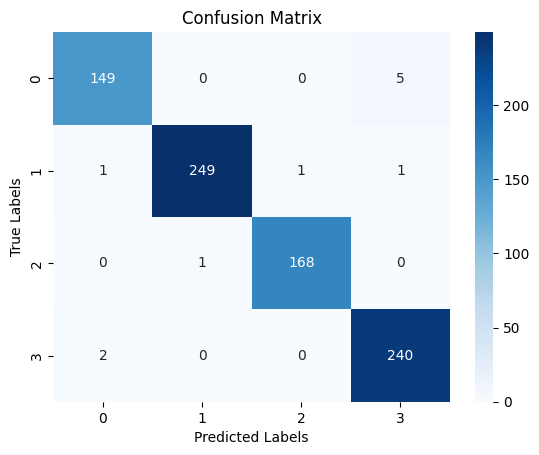

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

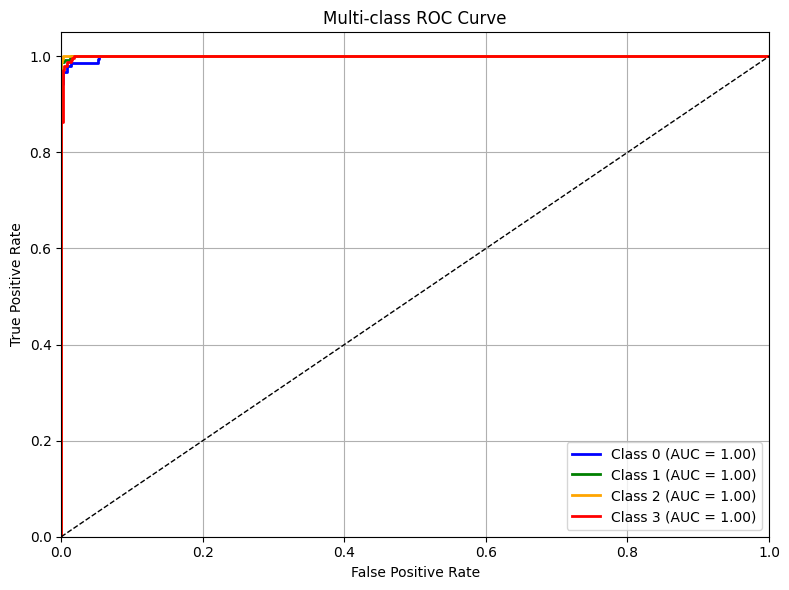

Macro-Averaged ROC-AUC: 0.9996
Weighted-Averaged ROC-AUC: 0.9996


In [ ]:
# ROC Curve
test_pred_proba = xgb_model.predict_proba(X_test_combined)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Macro and weighted ROC-AUC
macro_roc_auc = roc_auc_score(y_test_bin, test_pred_proba, average='macro', multi_class='ovr')
weighted_roc_auc = roc_auc_score(y_test_bin, test_pred_proba, average='weighted', multi_class='ovr')
print(f"Macro-Averaged ROC-AUC: {macro_roc_auc:.4f}")
print(f"Weighted-Averaged ROC-AUC: {weighted_roc_auc:.4f}")


In [ ]:
import numpy as np

cm = confusion_matrix(y_test, test_pred)
specificity = []

for i in range(len(categories)):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    spec = TN / (TN + FP)
    specificity.append(spec)

for i, spec in enumerate(specificity):
    print(f"Specificity for class {categories[i]}: {spec:.4f}")


Specificity for class Benign: 0.9955
Specificity for class Pre: 0.9982
Specificity for class Pro: 0.9985
Specificity for class Early: 0.9896


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    specificities = []
    supports = []

    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificities.append(specificity)
        supports.append(cm[i, :].sum())  # Support: true instances of class i

    macro_specificity = np.mean(specificities)
    weighted_specificity = np.average(specificities, weights=supports)

    # PRINT OUTPUT
    print("Per-class Specificity:")
    for i, spec in enumerate(specificities):
        label = class_names[i] if class_names else str(i)
        print(f"  Class {label}: {spec:.4f}")

    print(f"\nMacro Average Specificity: {macro_specificity:.4f}")
    print(f"Weighted Average Specificity: {weighted_specificity:.4f}")

    return specificities, macro_specificity, weighted_specificity


In [ ]:
compute_specificity(y_test, test_pred, class_names=['Benign', 'Pre', 'Pro', 'Early'])


Per-class Specificity:
  Class Benign: 0.9955
  Class Pre: 0.9982
  Class Pro: 0.9985
  Class Early: 0.9896

Macro Average Specificity: 0.9954
Weighted Average Specificity: 0.9952


([np.float64(0.995475113122172),
  np.float64(0.9982300884955753),
  np.float64(0.9984567901234568),
  np.float64(0.9895652173913043)],
 np.float64(0.9954318022831271),
 np.float64(0.9951911014213701))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming `y_test` and `test_pred` are already defined
cm = confusion_matrix(y_test, test_pred)
num_classes = cm.shape[0]

# Store metrics for each class
metrics = {
    'Class': [],
    'TP': [],
    'TN': [],
    'FP': [],
    'FN': []
}

for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    metrics['Class'].append(i)
    metrics['TP'].append(TP)
    metrics['TN'].append(TN)
    metrics['FP'].append(FP)
    metrics['FN'].append(FN)

# Convert to DataFrame for better display
df_metrics = pd.DataFrame(metrics)
print(df_metrics)


   Class   TP   TN  FP  FN
0      0  149  660   3   5
1      1  249  564   1   3
2      2  168  647   1   1
3      3  240  569   6   2


In [ ]:
img_size=224

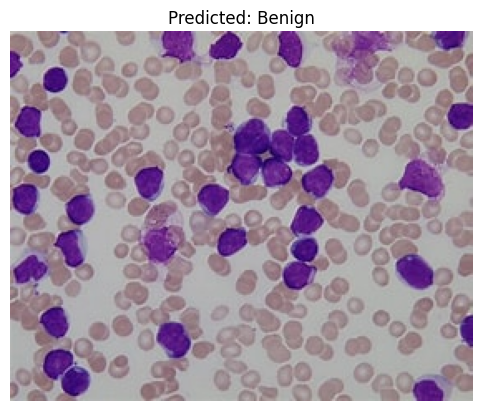

In [ ]:
# Map class indices to names
class_names = ['Benign', 'Pre', 'Pro', 'Early']

def preprocess_single_image(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or cannot be opened.")

    # Resize and convert to 3 channels
    img = cv2.resize(img, (img_size, img_size))
    img = np.expand_dims(img, axis=-1)  # shape (224,224,1)
    img = np.repeat(img, 3, axis=-1)    # shape (224,224,3)
    img = img / 255.0  # normalize
    img = np.expand_dims(img, axis=0)   # batch dimension: shape (1,224,224,3)
    return img

def extract_single_image_features(img_tensor):
    features = []
    for model in [efficientnet, resnet, densenet, inception]:
        feature = model.predict(img_tensor, verbose=0)
        features.append(feature)
    combined_features = np.concatenate(features, axis=1)
    return combined_features

def predict_single_image(image_path):
    preprocessed_img = preprocess_single_image(image_path)
    combined_features = extract_single_image_features(preprocessed_img)
    prediction = xgb_model.predict(combined_features)
    predicted_class = class_names[int(prediction[0])]
    return predicted_class

# Example usage:
image_path = "/content/new_input.jpg"  # Replace with your test image
result = predict_single_image(image_path)
img = cv2.imread(image_path)
if img is not None:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display in matplotlib
    plt.imshow(img_rgb)
    plt.title("Predicted: " + result)
    plt.axis('off')  # Hide axis
    plt.show()
else:
    print("Failed to load image.")
